In [1]:
%reload_ext autoreload
%autoreload 2
%aimport -sklearn, matplotlib, numpy, seaborn

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import binary_assessment 
import calibration 
%matplotlib inline

# Set plotting aesthetics

In [70]:
mpl.rcParams.update({'font.size': 15})
mpl.rcParams.update({"axes.grid" : True, "grid.linestyle": '--', 
                     "grid.alpha": 0.8, "grid.color": "black"})
mpl.rcParams.update({"lines.linewidth" : 3})

# Read data and create training/calibration/test splits
### (calibration split is like a validation split)

In [54]:
data = np.loadtxt('credit.csv', delimiter=',', dtype=str, skiprows=2)
np.random.seed(42)
X = data[:,1:-1]
Y = data[:,-1].astype('int')
X = preprocessing.scale(X)

X, XTest, Y, YTest = train_test_split(
    X, Y, test_size=5000)

XTrain, XCalib, YTrain, YCalib = train_test_split(
    X, Y, test_size=5000)

# Train base logistic regression model

In [56]:
logisticRegression = LogisticRegression(random_state=0, solver='lbfgs').fit(XTrain, YTrain)

print('Train accuracy: ', clf.score(XTrain, YTrain))
print('Calibration accuracy: ', clf.score(XCalib, YCalib))
print('Test accuracy: ', clf.score(XTest, YTest))

Train accuracy:  0.8103
Calibration accuracy:  0.8162
Test accuracy:  0.8074


# Assess logistic regression

Using 15 adaptive bins for plotting reliability diagram.
Using 15 adaptive bins for making validity plot.
Using 15 adaptive bins for ECE estimation.


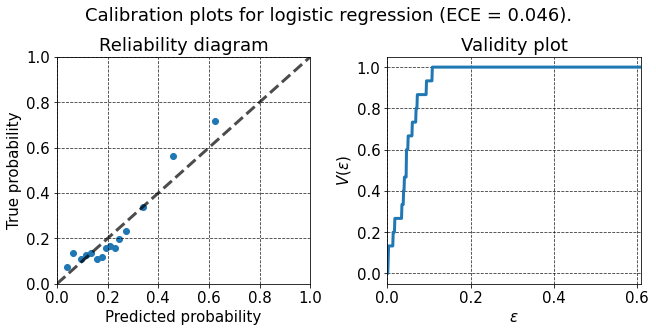

In [71]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4.5), constrained_layout=True)
predictedScores = logisticRegression.predict_proba(XTest)[:,1]
binary_assessment.reliability_diagram(YTest, predictedScores, ax[0])

binary_assessment.validity_plot(YTest, predictedScores, ax[1])
fig.suptitle('Calibration plots for logistic regression (ECE = {:.3f}).'.format(binary_assessment.ece(YTest, predictedScores)));
ax[0].set_title('Reliability diagram')
ax[1].set_title('Validity plot');

# Recalibrate using histogram binning

In [52]:
# initialize recalibrator and set number of bins
hb = calibration.HB_binary()
hb.n_bins = 15

In [57]:
# recalibrate output of logistic regression
calibrationScores = logisticRegression.predict_proba(XCalib)[:,1]
hb.fit(calibrationScores, YCalib)

# Assess histogram binning

Using 15 adaptive bins for plotting reliability diagram.
Using 15 adaptive bins for making validity plot.
Using 15 adaptive bins for ECE estimation.


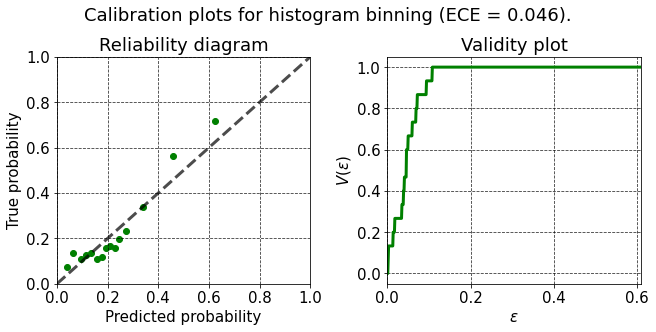

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4.5), constrained_layout=True)

binary_assessment.reliability_diagram(YTest, predictedScores, ax[0], color='g')
binary_assessment.validity_plot(YTest, predictedScores, ax[1], color='g')
fig.suptitle('Calibration plots for histogram binning (ECE = {:.3f}).'.format(binary_assessment.ece(YTest, predictedScores)));
ax[0].set_title('Reliability diagram')
ax[1].set_title('Validity plot');